# Задача регрессии для изображений

## Импорт библиотек

In [1]:
# Основные библиотеки
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision.transforms import v2


In [2]:
# Вспомогательные библиотеки

import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

# для загрузки изображений
from PIL import Image 

# для отображения прогресс-бар при работе с циклами
from tqdm import tqdm

In [3]:
# Библиотеки для загрузки данных

import struct
import sys

from array import array
from os import path

In [4]:
# выбор процессора
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Генерация изображений с белыми квадратами на черном фоне

In [30]:
# Проверка, куда сохраняю файлы

BWSquares_ds_path = os.path.abspath(os.path.join(os.getcwd(), '..', '_datasets\\BWSquares'))
print("Папка будет создана здесь:", output_path)

Папка будет создана здесь: C:\Users\metel\education\neural_networks_course\_datasets\BWSquares


In [36]:
BWSquares_coords = os.path.join(BWSquares_ds_path, 'coords.json')

In [33]:
# Создание директории для датасета
if not os.path.isdir(BWSquares_ds_path):
    os.mkdir(BWSquares_ds_path)

# Генерация 100000 черных изображений 64x64, 0-50 = оттенки черного
img = np.random.randint(0, 50, [100000, 64, 64], dtype=np.uint8)
# Генерация 100000 белых квадратов 15x15  100-200 = оттенки белого
white_squares = np.random.randint(100, 200, [100000, 15, 15], dtype=np.uint8)

# Массив для координат центра квадрата
coords = np.empty([100000, 2])

data = {}
for i in range(img.shape[0]):
    # Случайные координаты центра квадрата (в пределах 20-44)
    x = np.random.randint(20, 44)
    y = np.random.randint(20, 44)
    
    # Вставка белого квадрата в черное изображение
    img[i, (y - 7):(y + 8), (x - 7):(x + 8)] = white_squares[i]
    
    # Сохранение координат
    coords[i] = [y, x]
    
    # Сохранение изображения как JPEG
    name_img = f'img_{i}.jpeg'
    path_img = os.path.join(BWSquares_ds_path, name_img)
    image = Image.fromarray(img[i])
    image.save(path_img)
    
    # Добавление в словарь аннотаций
    data[name_img] = [y, x]

# Сохранение всех аннотаций в JSON файл
with open(BWSquares_coords, 'w') as f:
    json.dump(data, f, indent=2)   

## Создание пользовательского класса BWSquare_DS

In [37]:
# проверка для дальнейшего использования

with open(BWSquares_coords, 'r') as f:
            target_dict = json.load(f)
print(type(target_dict))  # <class 'dict'>
print(len(target_dict))   # количество элементов
print(target_dict['img_4.jpeg'])

<class 'dict'>
100000
[34, 32]


In [41]:
class BWSquare_DS(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

        self.img_list = []
        with open(BWSquares_coords, 'r') as f:
            self.target_dict = json.load(f)
            
        for root, dirs, files in os.walk(BWSquares_ds_path):
            for file in files:
                full_path = os.path.join(BWSquares_ds_path, file)
                if file in self.target_dict:
                    self.img_list.append((full_path, self.target_dict[file]))

        self.len_dataset = len(self.img_list)

        

    def __len__(self):
        return self.len_dataset

    def __getitem__(self, index):


        if self.transform is not None:
            img = Image.open(self.img_list[index][0])
            img = self.transform(img)
            coord = torch.tensor(self.img_list[index][1], dtype=torch.float32)

        else:
            img = np.array(Image.open(self.img_list[index][0]))
            coord = np.array(self.img_list[index][1])
        
        return img, coord
        

In [42]:
bws_dataset = BWSquare_DS(BWSquares_ds_path)

In [43]:
len(bws_dataset)

100000

Координаты центра: [21 40]


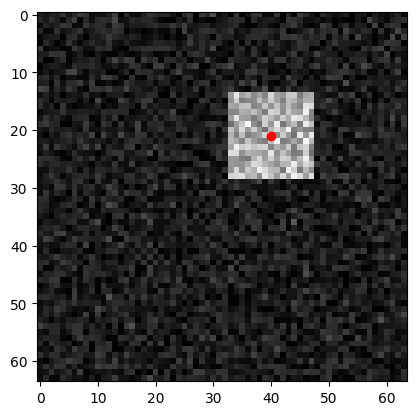

In [44]:
img, coord = bws_dataset[1874]
print(f'Координаты центра: {coord}')
plt.scatter(coord[1], coord[0], marker='o', color='red') # (x, y, marker=кружок, color=красный)
plt.imshow(img, cmap='gray')
plt.show() #красивый вывод (без наименования/характеристик объекта)

### Обучающая, Валидационная и Тестовая выборки

In [45]:
bws_train_data, bws_val_data, bws_test_data = random_split(bws_dataset, [0.7, 0.1, 0.2])

In [46]:
print(f'Длина тренировочных данных: {len(bws_train_data)}')
print(f'Длина валидационных данных: {len(bws_val_data)}')
print(f'Длина тестового данных:     {len(bws_test_data)}')

Длина тренировочных данных: 70000
Длина валидационных данных: 10000
Длина тестового данных:     20000


In [47]:
# Разбиение на батчи

bws_train_loader = DataLoader(bws_train_data, batch_size=64, shuffle=True)
bws_val_loader = DataLoader(bws_val_data, batch_size=64, shuffle=False)
bws_test_loader = DataLoader(bws_test_data, batch_size=64, shuffle=False)

In [ ]:
for i, (samples, target) in enumerate(bws_train_loader):
     if i < 3:
         print(f"Номер batch = {i+1}")
         print(f"    размер samples = {samples.shape}")
         print(f"    размер target = {target.shape}")

print('\n ...... \n')
print(f"Номер batch = {i+1}")
print(f"    размер samples = {samples.shape}")
print(f"    размер target = {target.shape}")

Номер batch = 1
    размер samples = torch.Size([64, 64, 64])
    размер target = torch.Size([64, 2])
Номер batch = 2
    размер samples = torch.Size([64, 64, 64])
    размер target = torch.Size([64, 2])
Номер batch = 3
    размер samples = torch.Size([64, 64, 64])
    размер target = torch.Size([64, 2])


### Применение трансформаций

In [48]:
bws_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(dtype = torch.float32, scale=True),
        v2.Normalize(mean=(0.5,), std = (0.5,))
    ]
)                            

In [51]:
bws_dataset = BWSquare_DS(BWSquares_ds_path, transform=bws_transform)

In [52]:
bws_img, coord = bws_dataset[7]

print(f'\033[94mimg:\033[0m')
print(f'   {type(bws_img)}')
print(f'   {bws_img.shape}')
print(f'   {bws_img.dtype}')
print(f'   min = {bws_img.min()}, max = {bws_img.max()}')

print(f'\033[94mcoord:\033[0m')
print(f'   {type(coord)}')
print(f'   {coord.shape}')
print(f'   {coord.dtype}')
print(f'\n   {coord}')

img:
   <class 'torchvision.tv_tensors._image.Image'>
   torch.Size([1, 64, 64])
   torch.float32
   min = -1.0, max = 0.6156864166259766
coord:
   <class 'torch.Tensor'>
   torch.Size([2])
   torch.float32

   tensor([21., 25.])


In [53]:
# Разбиение на выборки
bws_train_data, bws_val_data, bws_test_data = random_split(bws_dataset, [0.7, 0.1, 0.2])

In [54]:
# Разбиение на батчи

bws_train_loader = DataLoader(bws_train_data, batch_size=32, shuffle=True)
bws_val_loader = DataLoader(bws_val_data, batch_size=32, shuffle=False)
bws_test_loader = DataLoader(bws_test_data, batch_size=32, shuffle=False)

In [55]:
bws_imgs, bws_classes = next(iter(bws_train_loader))

print(f'\033[94mimg:\033[0m')
print(f'   {type(bws_imgs)}')
print(f'   {bws_imgs.shape}')
print(f'   {bws_imgs.dtype}')

print(f'\033[94mclass:\033[0m')
print(f'   {type(bws_classes)}')
print(f'   {bws_classes.shape}')
print(f'   {bws_classes.dtype}')

img:
   <class 'torch.Tensor'>
   torch.Size([32, 1, 64, 64])
   torch.float32
class:
   <class 'torch.Tensor'>
   torch.Size([32, 2])
   torch.float32


### Создание модели для задачи регрессии

In [56]:
class RegModel(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 128)
        self.layer_2 = nn.Linear(128, output)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.act(x)
        out = self.layer_2(x)

        return out

In [57]:
model_regression = RegModel(64*64, 2).to(device)

In [58]:
loss_regression = nn.MSELoss()
opt_regression = torch.optim.Adam(model_regression.parameters(), lr = 0.001)

In [59]:
# проверка правильности построения модели при помощи рандомного тензора

check_input = torch.rand([16,64*64], dtype = torch.float32).to(device)
check_output = model_regression(check_input)
check_output.shape

torch.Size([16, 2])

## Тренировка модели

#### Подготовка

In [60]:
# разбор команды: (будем использовать дальше)
# train_true_answers += (targets == torch.round(pred)).all(dim=1).sum().item()

pred = torch.tensor([[25.1, 44.8], [52.3, 27.8], [12.7, 37.4], [29.3, 27.2]], dtype=torch.float32, requires_grad=True).to(device)
target = torch.tensor([[25, 45], [53, 28], [13, 38], [36, 28]], dtype=torch.float32).to(device)

print("Predicted:")
print(pred)
print("\nTarget:")
print(target)

Predicted:
tensor([[25.1000, 44.8000],
        [52.3000, 27.8000],
        [12.7000, 37.4000],
        [29.3000, 27.2000]], device='cuda:0', grad_fn=<ToCopyBackward0>)

Target:
tensor([[25., 45.],
        [53., 28.],
        [13., 38.],
        [36., 28.]], device='cuda:0')


In [61]:
torch.round(pred)

tensor([[25., 45.],
        [52., 28.],
        [13., 37.],
        [29., 27.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [62]:
torch.round(pred) == target

tensor([[ True,  True],
        [False,  True],
        [ True, False],
        [False, False]], device='cuda:0')

In [63]:
# смотрим по первой оси (построчно) совпала ли точка полностью (по двум координатам)
(torch.round(pred) == target).all(dim=1)

tensor([ True, False, False, False], device='cuda:0')

In [64]:
# суммируем и берем значение из тензора
(torch.round(pred) == target).all(dim=1).sum().item()

1

#### Класс EarlyStopping

In [65]:
class EarlyStopping:
    def __init__(self, mode='min', patience=10, threshold=0.0001, threshold_mode='rel'):
        if mode not in {'min', 'max'}:
            raise ValueError(f"Параметр mode может принимать только значения max и min.")
        if threshold_mode not in {'rel', 'abs'}:
            raise ValueError(f"Параметр threshold_mode может принимать только значения rel и abs.")
        if not isinstance(patience, int):
            raise TypeError(f"Параметр patience должен быть целым числом.")
        if not isinstance(threshold, float):
            raise TypeError(f"Параметр threshold должен быть float.")
        if threshold >= 1.0:
            raise ValueError(f"Параметр threshold должен быть меньше 1,0.")
        
        self.mode = mode
        self.patience = patience
        self.threshold = threshold
        self.threshold_mode = threshold_mode
        self.count = 0
        self.best = None


    def __call__(self, tracked_parameter): # tracked_parameter - это либо ф-ция потерь, либо значение метрики
        current = float(tracked_parameter)
        
        if self.best is None:
            self.best = current
            return False
        
        if self.changed_better(current, self.best):
            self.best = current
            self.count = 0
        else:
            self.count += 1
        
        if self.count >= self.patience:
            return True  # сигнал к остановке
        return False  # продолжаем обучение


    def changed_better(self, current, best):
        if self.mode == 'min' and self.threshold_mode == 'rel':
            return current < best * (1 - self.threshold)
        elif self.mode == 'min' and self.threshold_mode == 'abs':
            return current < best - self.threshold
        elif self.mode == 'max' and self.threshold_mode == 'rel':
            return current > best * (1 + self.threshold)
        else:  # mode == 'max' and threshold_mode == 'abs'
            return current > best + self.threshold


#### ReduceLROnPlateau

In [66]:
reg_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                            opt_regression,       # оптимизатор
                            mode='min',           # 'max' или 'min'
                            factor=0.1,           # коэффициент, на который будет умножен lr
                            patience=5            # кол-во эпох без улучшения отслеживаемого параметра
                        )

earlystopping = EarlyStopping(mode='min', patience = 10)

#### Обучение модели

In [67]:
# информация о модели, которую будем сохранять во время обучения

str_info = '''
class RegModel(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 128)
        self.layer_2 = nn.Linear(128, output)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.act(x)
        out = self.layer_2(x)

        return out
'''

**Приступаем к тренировке**

In [68]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
reg_lr_list = []
reg_best_loss = None
threshold = 0.0001
last_saved_reg_model = ''

In [70]:
EPOCHS = 30

for epoch in range(EPOCHS):

    #режим тренировки
    model_regression.train()
    running_train_loss = []
    train_true_answers = 0
    train_loop = tqdm(bws_train_loader, leave=False)
    for x, targets in train_loop:
        # (batch_size, 1, 64, 64) -> (batch_size, 64*64)
        x = x.reshape(-1, 64*64).to(device)
        # (batch_size, tensor[float, float]) -> оставляем как есть
        targets = targets.to(device)


        # прямой проход + расчет ошибки модели
        pred = model_regression(x)
        # pred - ответ модели,  target - правильные ответы -> подаем на вход ф-ции потерь
        loss = loss_regression(pred, targets)

        # обратный проход
        opt_regression.zero_grad() #обнуляем градиенты для каждого батча
        loss.backward() # рассчитываем градиентами для текущего батча

        # шаг оптимизации
        opt_regression.step() # Используем градиенты из шага выше для обновления весов

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)

        train_true_answers += (targets == torch.round(pred)).all(dim=1).sum().item()

        train_loop.set_description(f'Epoch: [{epoch+1}/{EPOCHS}], train_loss = {mean_train_loss:.4f}') 

    # Расчет метрик
    train_accuracy = train_true_answers/len(bws_train_data)
    
    # Сохранение значений функции потерь
    train_loss.append(mean_train_loss)
    train_acc.append(train_accuracy)
    

    #режим оценки
    model_regression.eval()
    with torch.no_grad():
        running_val_loss = []
        val_true_answers = 0
        val_loop = tqdm(bws_val_loader, leave=False)
        for x, targets in val_loop:
            # (batch_size, 1, 64, 64) -> (batch_size, 64*64)
            x = x.reshape(-1, 64*64).to(device)
            # (batch_size, tensor[float, float]) -> оставляем как есть
            targets = targets.to(device)

            # прямой проход + расчет ошибки модели
            pred = model_regression(x)
            # pred - ответ модели,  target - правильные ответы -> подаем на вход ф-ции потерь
            loss = loss_regression(pred, targets)


            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)

            val_loop.set_description(f'Epoch: [{epoch+1}/{EPOCHS}], train_loss = {mean_val_loss:.4f}') 

            val_true_answers += (targets == torch.round(pred)).all(dim=1).sum().item()

        # Расчет метрик
        val_accuracy = val_true_answers / len(bws_val_data)
        
        # Сохранение значений функции потерь
        val_loss.append(mean_val_loss)
        val_acc.append(val_accuracy)

    reg_lr_scheduler.step(mean_val_loss)
    lr = reg_lr_scheduler.get_last_lr()[0]
    reg_lr_list.append(lr)
    print(lr)

    print(f'Epoch: [{epoch+1}/{EPOCHS}], train_loss = {mean_train_loss:.4f}, train_acc={train_accuracy:.4f}, val_loss={mean_val_loss:.4f}, val_acc={val_accuracy:.4f}, lr={lr:.4f}')

    if reg_best_loss is None:
        reg_best_loss = mean_val_loss

    if mean_val_loss < reg_best_loss - reg_best_loss * threshold:
        best_loss = mean_val_loss

        checkpoint = {
                        'info': str_info,                                     # текстовая информация о модели
                        'state_model': model_regression.state_dict(),         # веса модели
                        'state_opt': opt_regression.state_dict(),             # состояние оптимизатора
                        'state_lr_scheduler': reg_lr_scheduler.state_dict(),  # состояние scheduler
                        'loss': {                                  # метрики потерь
                            'train_loss': train_loss,
                            'val_loss': val_loss,
                            'best_loss': reg_best_loss
                        },
                        'metric': {                                # метрики accuracy
                            'train_acc': train_acc,
                            'val_acc': val_acc,
                        },
                        'lr': reg_lr_list,                         # история learning rate
                        'epoch': {                                 # информация об эпохах
                            'EPOCHS': EPOCHS,
                            'save_epoch': epoch
                        }
                    }

        if os.path.exists(last_saved_reg_model):
            os.remove(last_saved_reg_model)
        last_saved_reg_model = f'models/bws_model_checkpoint_epoch_{epoch+1}.pt'
        torch.save(checkpoint, last_saved_reg_model)
        
        print(f' Эпоха {epoch+1}: функция потерь при валидации - {mean_val_loss:.4f}', end='\n\n')
        print(f' Модель: {last_saved_reg_model}')

    if earlystopping(mean_val_loss):
        print(f'\033[31mОбучение остановлено на {epoch + 1} эпохе.\033[0m')
        break
        

0.001
Epoch: [1/30], train_loss = 0.1138, train_acc=0.7438, val_loss=0.1086, val_acc=0.7562, lr=0.0010


0.001
Epoch: [2/30], train_loss = 0.1256, train_acc=0.7120, val_loss=0.2068, val_acc=0.4578, lr=0.0010


0.001
Epoch: [3/30], train_loss = 0.1123, train_acc=0.7547, val_loss=0.0939, val_acc=0.8103, lr=0.0010
 Эпоха 3: функция потерь при валидации - 0.0939

 Модель: models/bws_model_checkpoint_epoch_3.pt


0.001
Epoch: [4/30], train_loss = 0.0972, train_acc=0.7979, val_loss=0.0724, val_acc=0.8759, lr=0.0010
 Эпоха 4: функция потерь при валидации - 0.0724

 Модель: models/bws_model_checkpoint_epoch_4.pt


0.001
Epoch: [5/30], train_loss = 0.0851, train_acc=0.8387, val_loss=0.4856, val_acc=0.1170, lr=0.0010


0.001
Epoch: [6/30], train_loss = 0.0720, train_acc=0.8829, val_loss=0.0437, val_acc=0.9649, lr=0.0010
 Эпоха 6: функция потерь при валидации - 0.0437

 Модель: models/bws_model_checkpoint_epoch_6.pt


0.001
Epoch: [7/30], train_loss = 0.0672, train_acc=0.8971, val_loss=0.0832, val_acc=0.8530, lr=0.0010
 Эпоха 7: функция потерь при валидации - 0.0832

 Модель: models/bws_model_checkpoint_epoch_7.pt


0.001
Epoch: [8/30], train_loss = 0.0626, train_acc=0.9120, val_loss=0.0482, val_acc=0.9554, lr=0.0010
 Эпоха 8: функция потерь при валидации - 0.0482

 Модель: models/bws_model_checkpoint_epoch_8.pt


0.001
Epoch: [9/30], train_loss = 0.0595, train_acc=0.9212, val_loss=0.0692, val_acc=0.9129, lr=0.0010
 Эпоха 9: функция потерь при валидации - 0.0692

 Модель: models/bws_model_checkpoint_epoch_9.pt


0.001
Epoch: [10/30], train_loss = 0.0574, train_acc=0.9263, val_loss=0.0500, val_acc=0.9552, lr=0.0010
 Эпоха 10: функция потерь при валидации - 0.0500

 Модель: models/bws_model_checkpoint_epoch_10.pt


0.001
Epoch: [11/30], train_loss = 0.0551, train_acc=0.9356, val_loss=0.0683, val_acc=0.8945, lr=0.0010
 Эпоха 11: функция потерь при валидации - 0.0683

 Модель: models/bws_model_checkpoint_epoch_11.pt


0.0001
Epoch: [12/30], train_loss = 0.0522, train_acc=0.9402, val_loss=0.0514, val_acc=0.9523, lr=0.0001
 Эпоха 12: функция потерь при валидации - 0.0514

 Модель: models/bws_model_checkpoint_epoch_12.pt


0.0001
Epoch: [13/30], train_loss = 0.0280, train_acc=0.9926, val_loss=0.0339, val_acc=0.9858, lr=0.0001
 Эпоха 13: функция потерь при валидации - 0.0339

 Модель: models/bws_model_checkpoint_epoch_13.pt


0.0001
Epoch: [14/30], train_loss = 0.0286, train_acc=0.9914, val_loss=0.0323, val_acc=0.9871, lr=0.0001
 Эпоха 14: функция потерь при валидации - 0.0323

 Модель: models/bws_model_checkpoint_epoch_14.pt


0.0001
Epoch: [15/30], train_loss = 0.0285, train_acc=0.9916, val_loss=0.0421, val_acc=0.9683, lr=0.0001
 Эпоха 15: функция потерь при валидации - 0.0421

 Модель: models/bws_model_checkpoint_epoch_15.pt


0.0001
Epoch: [16/30], train_loss = 0.0282, train_acc=0.9922, val_loss=0.0295, val_acc=0.9897, lr=0.0001
 Эпоха 16: функция потерь при валидации - 0.0295

 Модель: models/bws_model_checkpoint_epoch_16.pt


0.0001
Epoch: [17/30], train_loss = 0.0280, train_acc=0.9928, val_loss=0.0299, val_acc=0.9903, lr=0.0001
 Эпоха 17: функция потерь при валидации - 0.0299

 Модель: models/bws_model_checkpoint_epoch_17.pt


0.0001
Epoch: [18/30], train_loss = 0.0278, train_acc=0.9926, val_loss=0.0323, val_acc=0.9845, lr=0.0001
 Эпоха 18: функция потерь при валидации - 0.0323

 Модель: models/bws_model_checkpoint_epoch_18.pt


0.0001
Epoch: [19/30], train_loss = 0.0272, train_acc=0.9932, val_loss=0.0307, val_acc=0.9874, lr=0.0001
 Эпоха 19: функция потерь при валидации - 0.0307

 Модель: models/bws_model_checkpoint_epoch_19.pt


0.0001
Epoch: [20/30], train_loss = 0.0271, train_acc=0.9935, val_loss=0.0335, val_acc=0.9841, lr=0.0001
 Эпоха 20: функция потерь при валидации - 0.0335

 Модель: models/bws_model_checkpoint_epoch_20.pt


0.0001
Epoch: [21/30], train_loss = 0.0271, train_acc=0.9936, val_loss=0.0292, val_acc=0.9899, lr=0.0001
 Эпоха 21: функция потерь при валидации - 0.0292

 Модель: models/bws_model_checkpoint_epoch_21.pt


0.0001
Epoch: [22/30], train_loss = 0.0266, train_acc=0.9934, val_loss=0.0347, val_acc=0.9828, lr=0.0001
 Эпоха 22: функция потерь при валидации - 0.0347

 Модель: models/bws_model_checkpoint_epoch_22.pt


0.0001
Epoch: [23/30], train_loss = 0.0267, train_acc=0.9942, val_loss=0.0285, val_acc=0.9910, lr=0.0001
 Эпоха 23: функция потерь при валидации - 0.0285

 Модель: models/bws_model_checkpoint_epoch_23.pt


0.0001
Epoch: [24/30], train_loss = 0.0263, train_acc=0.9943, val_loss=0.0320, val_acc=0.9855, lr=0.0001
 Эпоха 24: функция потерь при валидации - 0.0320

 Модель: models/bws_model_checkpoint_epoch_24.pt


0.0001
Epoch: [25/30], train_loss = 0.0262, train_acc=0.9946, val_loss=0.0285, val_acc=0.9901, lr=0.0001
 Эпоха 25: функция потерь при валидации - 0.0285

 Модель: models/bws_model_checkpoint_epoch_25.pt


0.0001
Epoch: [26/30], train_loss = 0.0259, train_acc=0.9942, val_loss=0.0333, val_acc=0.9838, lr=0.0001
 Эпоха 26: функция потерь при валидации - 0.0333

 Модель: models/bws_model_checkpoint_epoch_26.pt


Epoch: [27/30], train_loss = 0.0255:  84%|██████████████████████████████████▋      | 1848/2188 [02:39<00:29, 11.56it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

                                                                                                                       

0.0001
Epoch: [29/30], train_loss = 0.0253, train_acc=0.9950, val_loss=0.0295, val_acc=0.9902, lr=0.0001
 Эпоха 29: функция потерь при валидации - 0.0295

 Модель: models/bws_model_checkpoint_epoch_29.pt


0.0001
Epoch: [30/30], train_loss = 0.0255, train_acc=0.9950, val_loss=0.0296, val_acc=0.9902, lr=0.0001
 Эпоха 30: функция потерь при валидации - 0.0296

 Модель: models/bws_model_checkpoint_epoch_30.pt


#### Результаты тренировки модели

In [71]:
reg_lr_list

[0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001,
 0.0001]

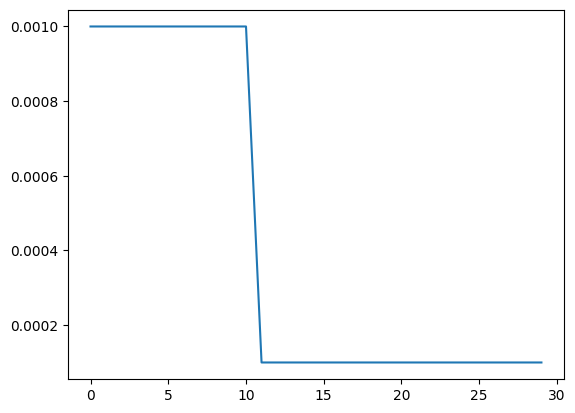

In [72]:
plt.plot(reg_lr_list)
plt.show()

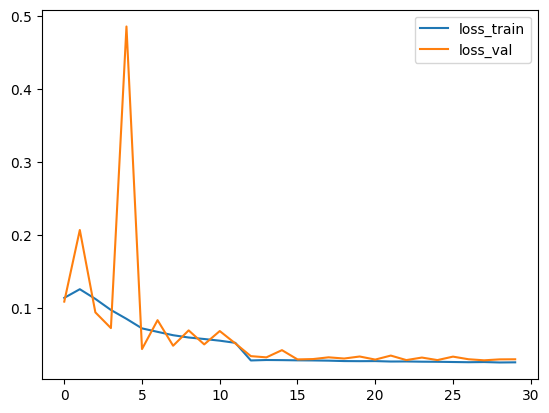

In [73]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['loss_train', 'loss_val'])
plt.show()

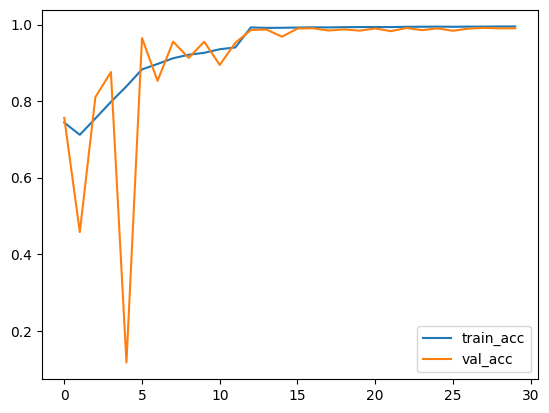

In [74]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train_acc', 'val_acc'])
plt.show()

## Загрузка модели

In [78]:
# Загрузка параметров модели

param_model= torch.load('models/bws_model_checkpoint_epoch_30.pt')

In [81]:
param_model

{'info': '\nclass RegModel(nn.Module):\n    def __init__(self, input, output):\n        super().__init__()\n        self.layer_1 = nn.Linear(input, 128)\n        self.layer_2 = nn.Linear(128, output)\n        self.act = nn.ReLU()\n\n    def forward(self, x):\n        x = self.layer_1(x)\n        x = self.act(x)\n        out = self.layer_2(x)\n\n        return out\n',
 'state_model': OrderedDict([('layer_1.weight',
               tensor([[-0.0146,  0.0156, -0.0106,  ...,  0.0097, -0.0034,  0.0127],
                       [-0.0108,  0.0050,  0.0179,  ...,  0.0172, -0.0032,  0.0082],
                       [ 0.0062,  0.0042,  0.0046,  ..., -0.0050,  0.0060, -0.0002],
                       ...,
                       [-0.0043,  0.0034,  0.0046,  ..., -0.0013,  0.0014,  0.0004],
                       [-0.0023, -0.0306, -0.0065,  ..., -0.0010,  0.0488, -0.0020],
                       [-0.0053, -0.0526, -0.0022,  ...,  0.0452, -0.0060, -0.0043]],
                      device='cuda:0')),
  

In [79]:
# Создание новой модели
new_reg_model = RegModel(64*64, 2).to(device)

In [83]:
# используем загруженные параметры для новой модели
new_reg_model.load_state_dict(param_model['state_model'])

<All keys matched successfully>

**Работа модели на примере**

Pred coord: tensor([23.2470, 39.8018])
Pred round-coord: tensor([23., 40.])
True coord: tensor([23., 40.])


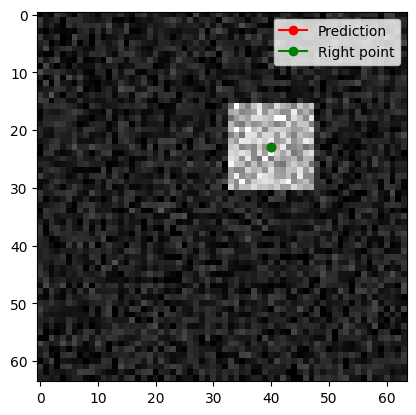

In [85]:
img, coord = bws_test_data[100]

new_reg_model.eval()
with torch.no_grad():
    pred = new_reg_model(img.view(1, 64*64).to(device)).detach().cpu()

y_pred = torch.round(pred[0])[0].item()
x_pred = torch.round(pred[0])[1].item() 

print(f'Pred coord: {pred[0]}')
print(f'\033[31mPred round-coord:\033[0m {torch.round(pred[0])}')
print(f'\033[32mTrue coord:\033[0m {coord}')

plt.imshow(img[0].numpy(), cmap='gray')
plt.plot(x_pred, y_pred, marker='o', color='red', label='Prediction')
plt.plot(coord[1].item(), coord[0].item(), marker='o', color='green', label='Right point')
plt.legend()
plt.show()

## Загрузка состояния модели для дальнейшего обучения

In [86]:
last_saved_reg_model = 'models/bws_model_checkpoint_epoch_30.pt'
load_model_state = torch.load(last_saved_reg_model)

In [87]:
print(load_model_state['info'])


class RegModel(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.layer_1 = nn.Linear(input, 128)
        self.layer_2 = nn.Linear(128, output)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = self.act(x)
        out = self.layer_2(x)

        return out



In [88]:
# Создание модели
load_reg_model = RegModel(64*64, 2).to(device)

new_loss_model = nn.MSELoss()
load_reg_opt = torch.optim.Adam(load_reg_model.parameters(), lr=0.001)
load_reg_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(load_reg_opt)

# Загрузка сохраненного состояния
load_reg_model.load_state_dict(load_model_state['state_model'])
load_reg_opt.load_state_dict(load_model_state['state_opt'])
load_reg_lr_scheduler.load_state_dict(load_model_state['state_lr_scheduler'])

In [89]:
# Загрузка параметров обучения
EPOCHS = load_model_state['epoch']['EPOCHS']  
save_epoch = load_model_state['epoch']['save_epoch']  

# Загрузка метрик потерь
train_loss = load_model_state['loss']['train_loss']  
val_loss = load_model_state['loss']['val_loss']  
reg_best_loss = load_model_state['loss']['best_loss']

# Загрузка метрик accuracy  
train_acc = load_model_state['metric']['train_acc']  
val_acc = load_model_state['metric']['val_acc']  

# Загрузка истории learning rate
reg_lr_list = load_model_state['lr']

In [90]:
EPOCHS = 100

In [196]:
# обучение - продолжение
for epoch in range(save_epoch + 1, EPOCHS):

    #режим тренировки
    load_reg_model.train()
    running_train_loss = []
    train_true_answers = 0
    train_loop = tqdm(bws_train_loader, leave=False)
    for x, targets in train_loop:
        # (batch_size, 1, 64, 64) -> (batch_size, 64*64)
        x = x.reshape(-1, 64*64).to(device)
        # (batch_size, tensor[float, float]) -> оставляем как есть
        targets = targets.to(device)


        # прямой проход + расчет ошибки модели
        pred = load_reg_model(x)
        # pred - ответ модели,  target - правильные ответы -> подаем на вход ф-ции потерь
        loss = new_loss_model(pred, targets)

        # обратный проход
        load_reg_opt.zero_grad() #обнуляем градиенты для каждого батча
        loss.backward() # рассчитываем градиентами для текущего батча

        # шаг оптимизации
        load_reg_opt.step() # Используем градиенты из шага выше для обновления весов

        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)

        train_true_answers += (targets == torch.round(pred)).all(dim=1).sum().item()

        train_loop.set_description(f'Epoch: [{epoch+1}/{EPOCHS}], train_loss = {mean_train_loss:.4f}') 

    # Расчет метрик
    train_accuracy = train_true_answers/len(bws_train_data)
    
    # Сохранение значений функции потерь
    train_loss.append(mean_train_loss)
    train_acc.append(train_accuracy)
    

    #режим оценки
    load_reg_model.eval()
    with torch.no_grad():
        running_val_loss = []
        val_true_answers = 0
        val_loop = tqdm(bws_val_loader, leave=False)
        for x, targets in val_loop:
            # (batch_size, 1, 64, 64) -> (batch_size, 64*64)
            x = x.reshape(-1, 64*64).to(device)
            # (batch_size, tensor[float, float]) -> оставляем как есть
            targets = targets.to(device)

            # прямой проход + расчет ошибки модели
            pred = load_reg_model(x)
            # pred - ответ модели,  target - правильные ответы -> подаем на вход ф-ции потерь
            loss = new_loss_model(pred, targets)


            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)

            val_loop.set_description(f'Epoch: [{epoch+1}/{EPOCHS}], train_loss = {mean_val_loss:.4f}') 

            val_true_answers += (targets == torch.round(pred)).all(dim=1).sum().item()

        # Расчет метрик
        val_accuracy = val_true_answers / len(bws_val_data)
        
        # Сохранение значений функции потерь
        val_loss.append(mean_val_loss)
        val_acc.append(val_accuracy)

    load_reg_lr_scheduler.step(mean_val_loss)
    lr = load_reg_lr_scheduler.get_last_lr()[0]
    reg_lr_list.append(lr)
    print(lr)

    print(f'Epoch: [{epoch+1}/{EPOCHS}], train_loss = {mean_train_loss:.4f}, train_acc={train_accuracy:.4f}, val_loss={mean_val_loss:.4f}, val_acc={val_accuracy:.4f}, lr={lr:.4f}')

    if reg_best_loss is None:
        reg_best_loss = mean_val_loss

    if mean_val_loss < reg_best_loss - reg_best_loss * threshold:
        best_loss = mean_val_loss

        checkpoint = {
                        'info': str_info,                                     # текстовая информация о модели
                        'state_model': load_reg_model.state_dict(),         # веса модели
                        'state_opt': load_reg_opt.state_dict(),             # состояние оптимизатора
                        'state_lr_scheduler': load_reg_lr_scheduler.state_dict(),  # состояние scheduler
                        'loss': {                                  # метрики потерь
                            'train_loss': train_loss,
                            'val_loss': val_loss,
                            'best_loss': reg_best_loss
                        },
                        'metric': {                                # метрики accuracy
                            'train_acc': train_acc,
                            'val_acc': val_acc,
                        },
                        'lr': reg_lr_list,                         # история learning rate
                        'epoch': {                                 # информация об эпохах
                            'EPOCHS': EPOCHS,
                            'save_epoch': epoch
                        }
                    }

        if os.path.exists(last_saved_reg_model):
            os.remove(last_saved_reg_model)
        last_saved_reg_model = f'models/bws_model_checkpoint_epoch_{epoch+1}.pt'
        torch.save(checkpoint, last_saved_reg_model)
        
        print(f' Эпоха {epoch+1}: функция потерь при валидации - {mean_val_loss:.4f}', end='\n\n')
        print(f' Модель: {last_saved_reg_model}')

    if earlystopping(mean_val_loss):
        print(f'\033[31mОбучение остановлено на {epoch + 1} эпохе.\033[0m')
        break
        

0.0001
Epoch: [5/5], train_loss = 0.2441, train_acc=1.7347, val_loss=0.2709, val_acc=0.9909, lr=0.0001


## Проверка модели

### Расчет метрик

In [199]:
load_reg_model.eval()
with torch.no_grad():
    running_test_loss = []
    test_true_answers = 0
    for x, targets in bws_test_loader:
        x = x.reshape(-1, 64*64).to(device)
        targets = targets.to(device)

        # прямой проход + расчет ошибки модели
        pred = load_reg_model(x)
        loss = new_loss_model(pred, targets)
        
        running_test_loss.append(loss.item())
        mean_test_loss = sum(running_test_loss)/len(running_test_loss)
            
        test_true_answers += (targets == torch.round(pred)).all(dim=1).sum().item()

    # Расчет метрик
    running_test_acc = test_true_answers / len(bws_test_data)

print(f'test_loss = {mean_test_loss:.4f}, train_acc={running_test_acc:.4f}', end = '\n\n')

test_loss = 0.2058, train_acc=0.9503



In [200]:
### test_loss = 0.0280, test_acc = 0.9914 - хорошие результаты - ориентир на них

### Проверка на примерах

Pred coord: tensor([25.1065, 25.3162])
Pred round-coord: tensor([25., 25.])
True coord: tensor([25., 25.])


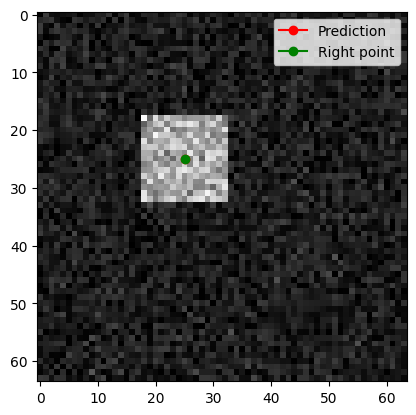

In [201]:
img, coord = bws_test_data[100]

load_reg_model.eval()
with torch.no_grad():
    pred = load_reg_model(img.view(1, 64*64).to(device)).detach().cpu()

y_pred = torch.round(pred[0])[0].item()
x_pred = torch.round(pred[0])[1].item() 

print(f'Pred coord: {pred[0]}')
print(f'\033[31mPred round-coord:\033[0m {torch.round(pred[0])}')
print(f'\033[32mTrue coord:\033[0m {coord}')

plt.imshow(img[0].numpy(), cmap='gray')
plt.plot(x_pred, y_pred, marker='o', color='red', label='Prediction')
plt.plot(coord[1].item(), coord[0].item(), marker='o', color='green', label='Right point')
plt.legend()
plt.show()

### Случаи с неверным предсказанием точки

In [202]:
load_reg_model.eval()
test_loader = DataLoader(bws_test_data, batch_size=len(bws_test_data))

# Получаем один батч со всем тестовым набором
with torch.no_grad():
    x, targets = next(iter(test_loader))
    
print(f"Входные данные: {x.shape}")
print(f"Целевые значения: {targets.shape}")

Входные данные: torch.Size([20000, 1, 64, 64])
Целевые значения: torch.Size([20000, 2])


In [204]:
# Делаем предсказания на всех тестовых данных
pred = load_reg_model(x.reshape(-1, 64*64).to(device)).detach().cpu()
    # x.reshape(-1, 64*64) - преобразуем изображения 64x64 в векторы 4096
    # .to(device) - отправляем на GPU если есть
    # .detach().cpu() - отцепляем от графа вычислений и возвращаем на CPU

# Находим примеры с НЕправильными предсказаниями
index = ~(torch.round(pred) == targets).all(dim=1)
    # torch.round(pred) == targets - сравнение округленных предсказаний с истинными значениями
    # .all(dim=1) - True если ВСЕ координаты совпали (и x и y)
    # ~ - инвертируем: теперь True там, где предсказание НЕправильное
    # index — это булев тензор


print(f"Из {len(bws_test_data)} \033[31mНЕправильно\033[0m предсказано {index.sum()}.", end='\n\n')

# Выбираем только ошибочные примеры
imgs_false_pred = x[index]           # изображения с ошибками - булева индексация
false_pred = pred[index]             # неправильные предсказания - булева индексация
rel_false_pred = targets[index]      # правильные значения (targets) -- булева индексация

Из 20000 НЕправильно предсказано 994.



Pred coord:    tensor([23.5670, 31.4940])
Pred round_coord: tensor([24., 31.])
True coord:    tensor([24., 32.])


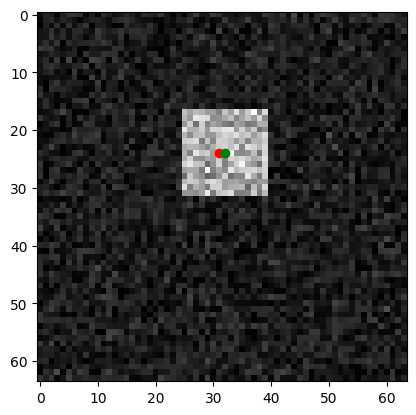

In [205]:
index_false_pred = 22
false_coords = false_pred[index_false_pred]
rel_coords = rel_false_pred[index_false_pred]

print(f'Pred coord:    {false_coords}')
print(f'\033[31mPred round_coord:\033[0m {torch.round(false_coords)}')
print(f'\033[32mTrue coord:\033[0m    {rel_coords}')

x_pred = torch.round(false_coords)[1].item()
y_pred = torch.round(false_coords)[0].item()

plt.imshow(imgs_false_pred[index_false_pred][0].numpy(), cmap='gray')
plt.plot(x_pred, y_pred, marker='o', color='red')
plt.plot(rel_coords[1].item(), rel_coords[0].item(), marker='o', color='green')
plt.show()